In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/test.csv


In [2]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [3]:
dailyData = pd.read_csv("/kaggle/input/bike-sharing-demand/train.csv")

# **EDA** 

In [4]:
dailyData.shape

(10886, 12)

In [5]:
dailyData.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


# **FINDING ALL THE DATATYPES**

In [6]:
dailyData.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

# **FEATURE ENGINEERING**

New Columns From "Datetime" Column

In [7]:
dailyData["date"] = dailyData.datetime.apply(lambda x : x.split()[0])
dailyData["hour"] = dailyData.datetime.apply(lambda x : x.split()[1].split(":")[0])
dailyData["weekday"] = dailyData.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
dailyData["month"] = dailyData.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
dailyData["season"] = dailyData.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
dailyData["weather"] = dailyData.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

Coercing To Category Type

In [8]:
categoryVariableList = ["hour","weekday","month","season","weather","holiday","workingday"]
for var in categoryVariableList:
    dailyData[var] = dailyData[var].astype("category")

In [9]:
dailyData  = dailyData.drop(["datetime"],axis=1)

[Text(0.5, 0, 'Variable Type'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Variables DataType Count')]

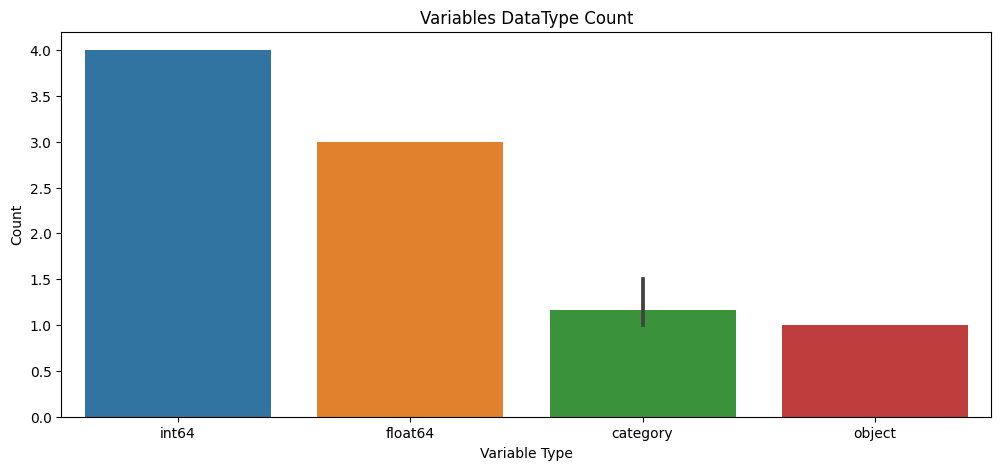

In [10]:
dataTypeDf = pd.DataFrame(dailyData.dtypes.value_counts()).reset_index()
dataTypeDf.columns = ["variableType", "count"]
dataTypeDf["variableType"] = dataTypeDf["variableType"].astype(str)

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
sn.barplot(data=dataTypeDf, x="variableType", y="count", ax=ax)
ax.set(xlabel='Variable Type', ylabel='Count', title="Variables DataType Count")


**Skewness In Distribution**

<Axes: >

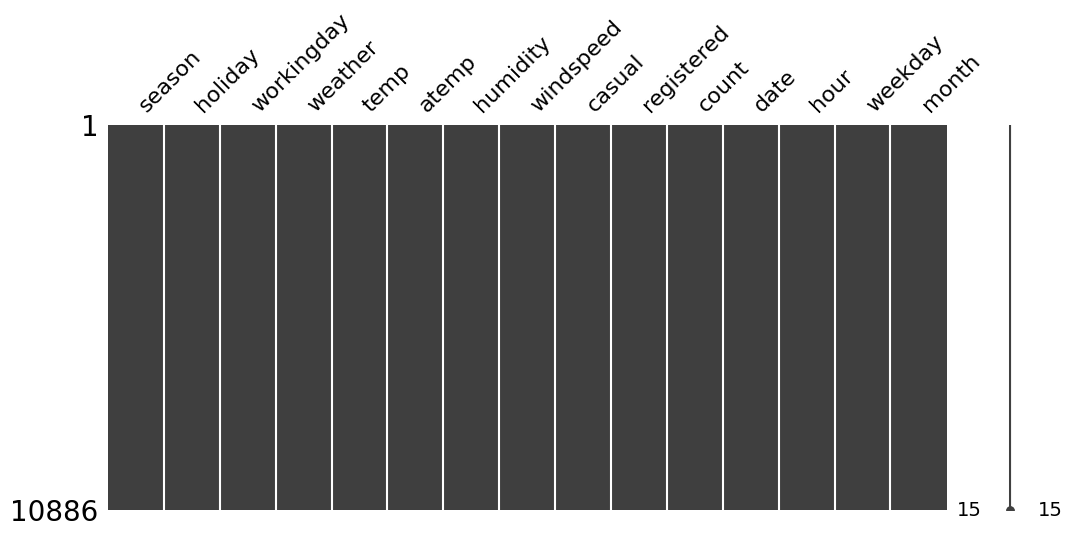

In [11]:
msno.matrix(dailyData,figsize=(12,5))

Outliers Analysis

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

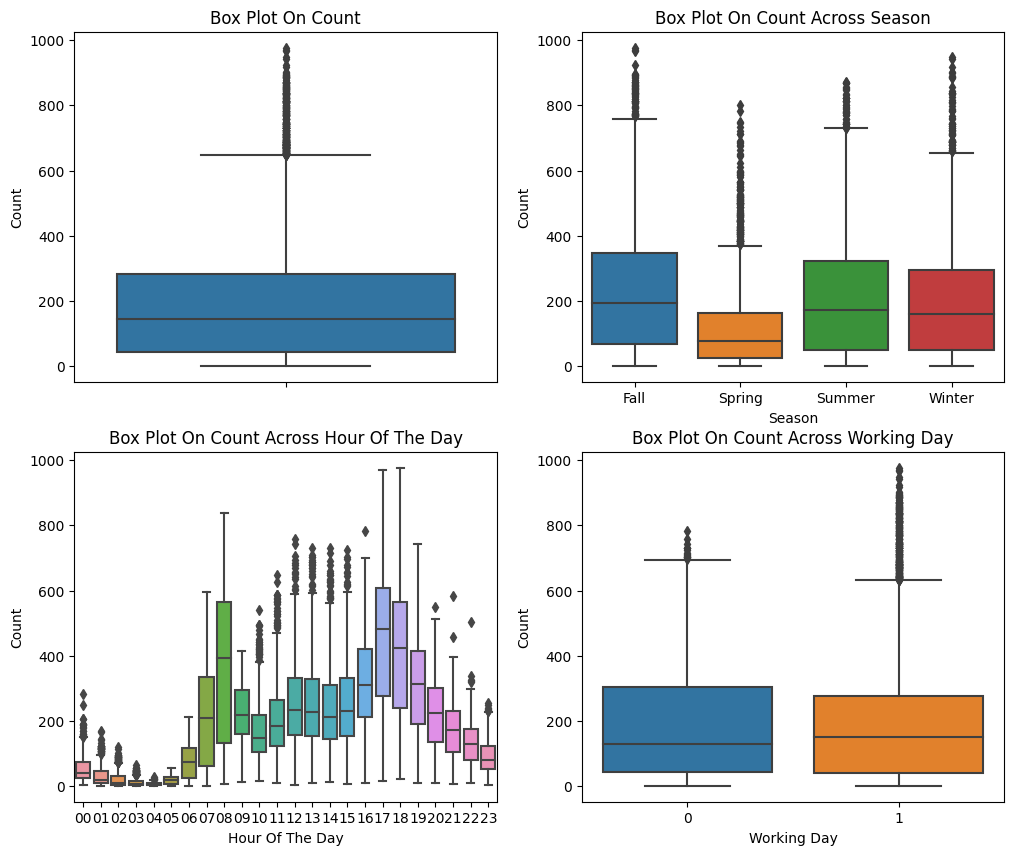

In [12]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data=dailyData,y="count",orient="v",ax=axes[0][0])
sn.boxplot(data=dailyData,y="count",x="season",orient="v",ax=axes[0][1])
sn.boxplot(data=dailyData,y="count",x="hour",orient="v",ax=axes[1][0])
sn.boxplot(data=dailyData,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

In [13]:
dailyDataWithoutOutliers = dailyData[np.abs(dailyData["count"]-dailyData["count"].mean())<=(3*dailyData["count"].std())] 

In [14]:
print ("Shape Of The Before Ouliers: ",dailyData.shape)
print ("Shape Of The After Ouliers: ",dailyDataWithoutOutliers.shape)

Shape Of The Before Ouliers:  (10886, 15)
Shape Of The After Ouliers:  (10739, 15)


# **Correlation Analysis**

<Axes: >

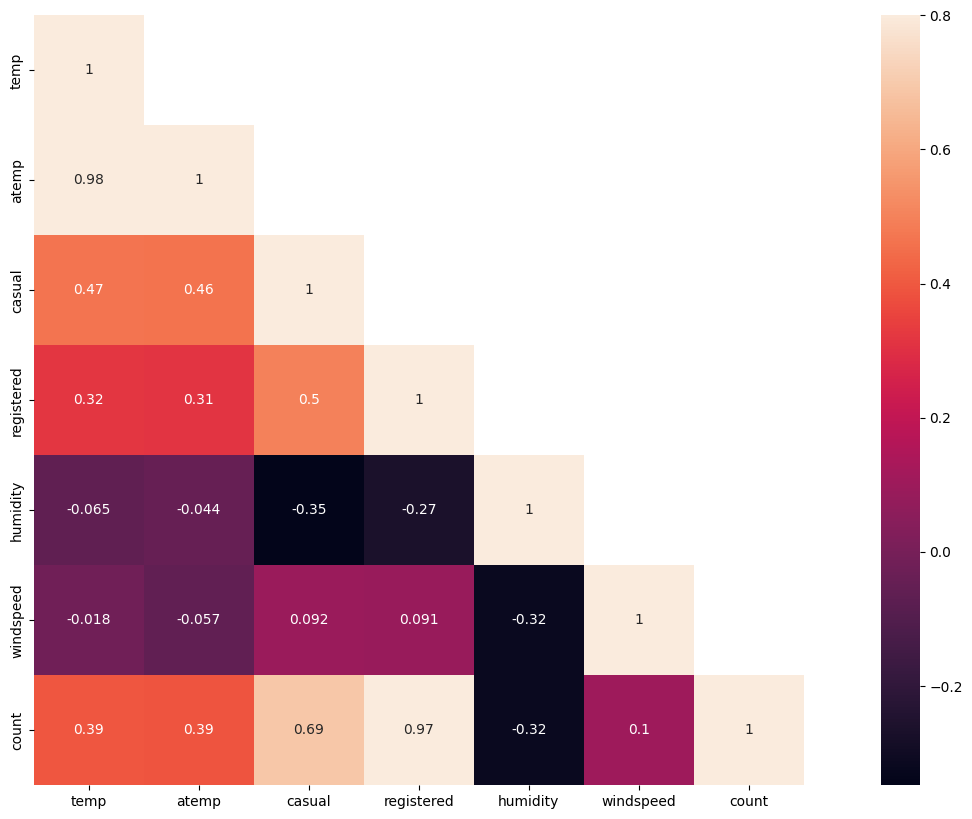

In [15]:
corrMatt = dailyData[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

<Axes: xlabel='humidity', ylabel='count'>

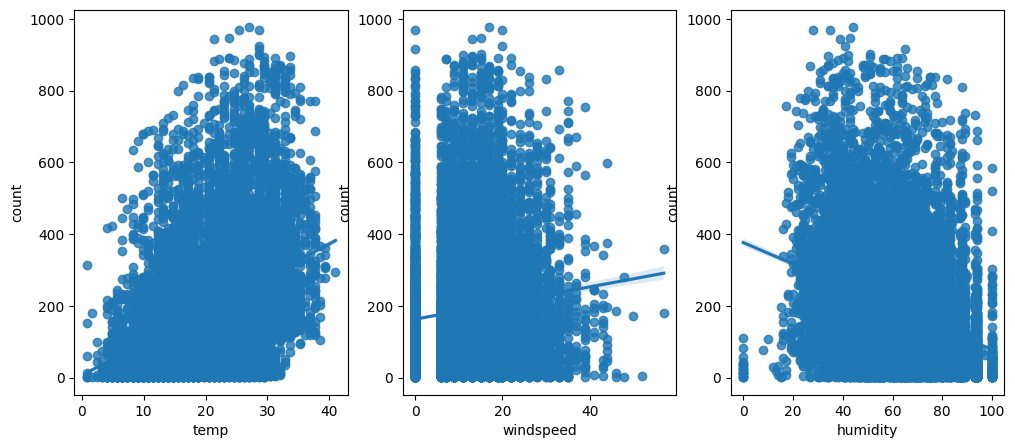

In [16]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sn.regplot(x="temp", y="count", data=dailyData,ax=ax1)
sn.regplot(x="windspeed", y="count", data=dailyData,ax=ax2)
sn.regplot(x="humidity", y="count", data=dailyData,ax=ax3)

/tmp/ipykernel_79/4097800041.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sn.distplot(dailyData["count"],ax=axes[0][0])
/tmp/ipykernel_79/4097800041.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sn.distplot(np.log(dailyDataWithoutOutliers["count"]),ax=axes[1][0])


((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229776, 4.562423868087807, 0.958117678090961))

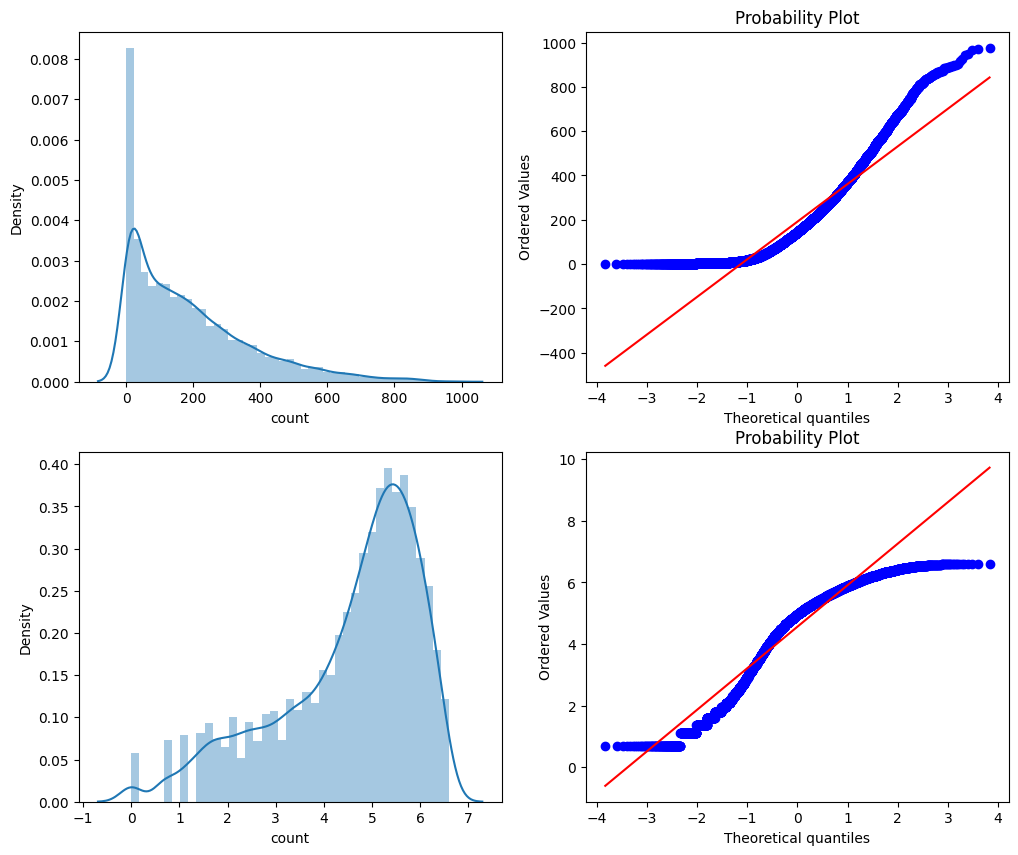

In [17]:
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sn.distplot(dailyData["count"],ax=axes[0][0])
stats.probplot(dailyData["count"], dist='norm', fit=True, plot=axes[0][1])
sn.distplot(np.log(dailyDataWithoutOutliers["count"]),ax=axes[1][0])
stats.probplot(np.log1p(dailyDataWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])

[Text(0.5, 0, 'Hour Of The Day'),
 Text(0, 0.5, 'Users Count'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across User Type'),
 None]

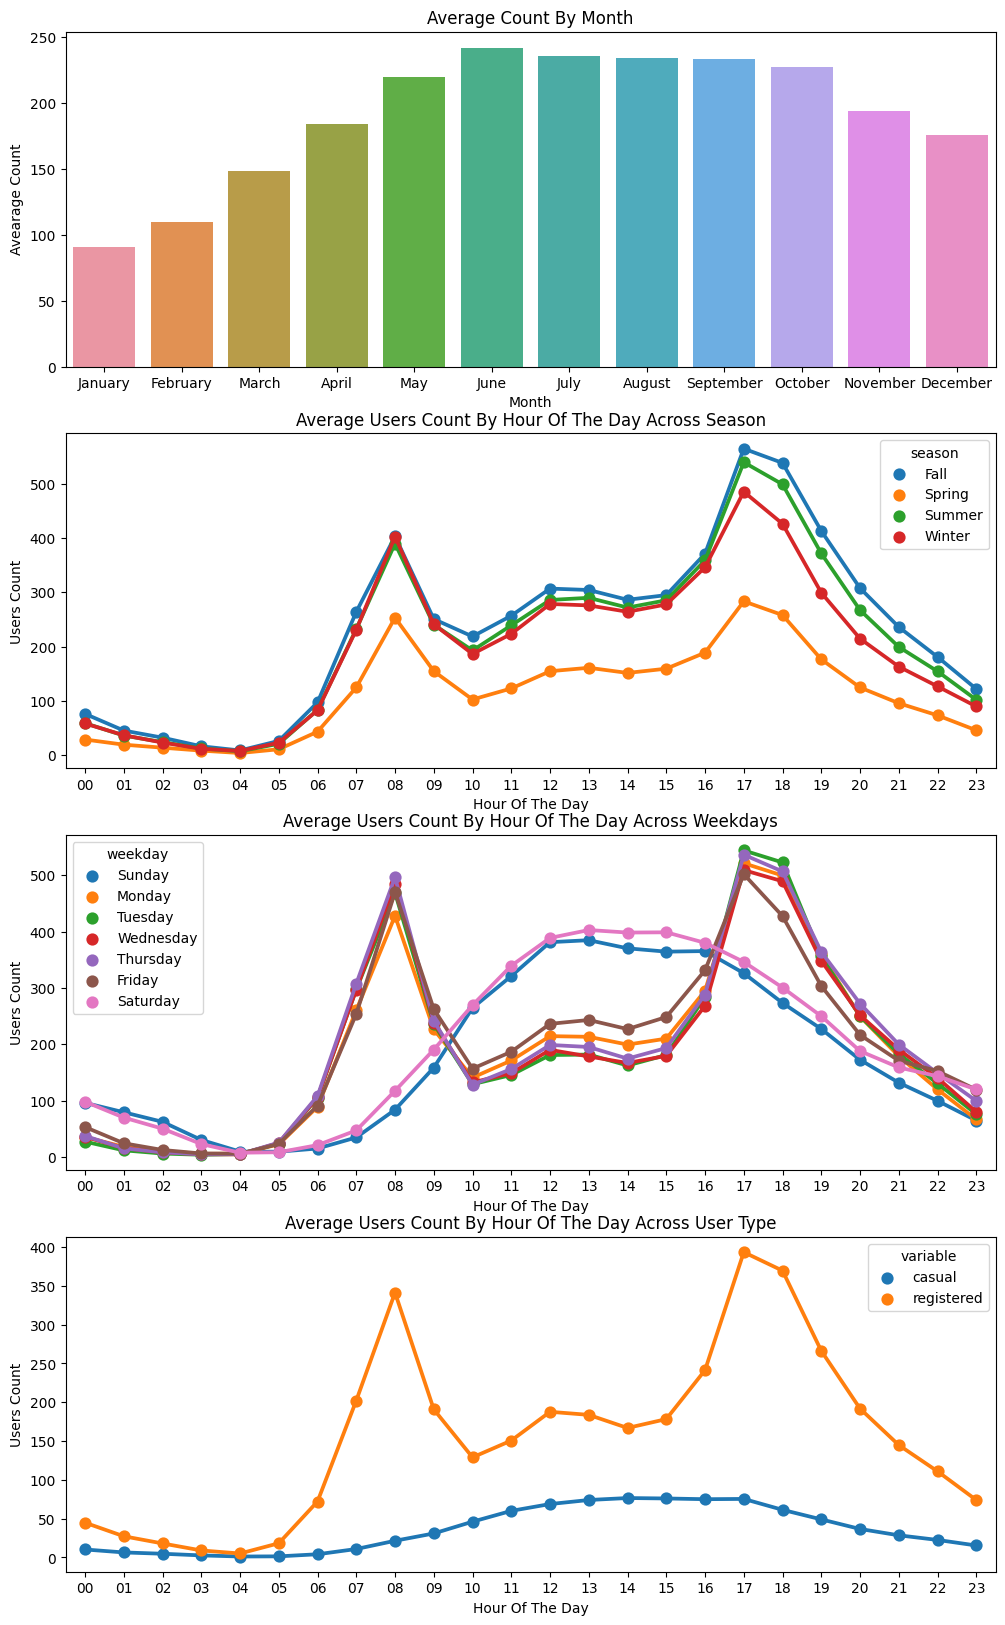

In [18]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(12,20)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(dailyData.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sn.barplot(data=monthSorted,x="month",y="count",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(dailyData.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(dailyData.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

hourTransformed = pd.melt(dailyData[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')

In [19]:
dataTrain = pd.read_csv("/kaggle/input/bike-sharing-demand/train.csv")
dataTest = pd.read_csv("/kaggle/input/bike-sharing-demand/test.csv")

In [20]:
data = pd.concat([dataTrain, dataTest], ignore_index=True)

In [21]:
data["date"] = data.datetime.apply(lambda x : x.split()[0])
data["hour"] = data.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
data["year"] = data.datetime.apply(lambda x : x.split()[0].split("-")[0])
data["weekday"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
data["month"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

In [22]:
from sklearn.ensemble import RandomForestRegressor

dataWind0 = data[data["windspeed"]==0]
dataWindNot0 = data[data["windspeed"]!=0]
rfModel_wind = RandomForestRegressor()
windColumns = ["season","weather","humidity","month","temp","year","atemp"]
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])

wind0Values = rfModel_wind.predict(X=dataWind0[windColumns])
dataWind0["windspeed"] = wind0Values
data = pd.concat([dataWindNot0, dataWind0])
data.reset_index(inplace=True)
data.drop('index', inplace=True, axis=1)


In [23]:
categoricalFeatureNames = ["season","holiday","workingday","weather","weekday","month","year","hour"]
numericalFeatureNames = ["temp","humidity","windspeed","atemp"]
dropFeatures = ['casual',"count","datetime","date","registered"]

In [24]:
for var in categoricalFeatureNames:
    data[var] = data[var].astype("category")

In [25]:
dataTrain = data[pd.notnull(data['count'])].sort_values(by=["datetime"])
dataTest = data[~pd.notnull(data['count'])].sort_values(by=["datetime"])
datetimecol = dataTest["datetime"]
yLabels = dataTrain["count"]
yLablesRegistered = dataTrain["registered"]
yLablesCasual = dataTrain["casual"]

In [26]:
dataTrain  = dataTrain.drop(dropFeatures,axis=1)
dataTest  = dataTest.drop(dropFeatures,axis=1)

In [27]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2

In [28]:
from sklearn.linear_model import LinearRegression
import numpy as np
import warnings
import pandas as pd

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Ensure dataTrain is numeric
dataTrain = dataTrain.select_dtypes(include=[np.number])

# Initialize linear regression model
lModel = LinearRegression()

# Train the model on log-transformed labels
yLabelsLog = np.log1p(yLabels)
lModel.fit(X=dataTrain, y=yLabelsLog)

# Make predictions (log scale)
preds = lModel.predict(X=dataTrain)

# Convert predictions back to original scale
preds_original = np.expm1(preds)

# Calculate RMSLE using original labels and predicted values
print("RMSLE Value For Linear Regression: ", rmsle(yLabels, preds_original, False))


RMSLE Value For Linear Regression:  None


RMSLE: 0.34639902177114423
RMSLE: 0.270792914856037
RMSLE: 0.29679415330158726
RMSLE: 0.259262828445787
RMSLE: 0.25958411074295107
RMSLE: 0.34639905307577123
RMSLE: 0.27079288306666616
RMSLE: 0.29679415413571153
RMSLE: 0.2592628315311493
RMSLE: 0.2595835758102368
RMSLE: 0.34639908785897705
RMSLE: 0.27079284774626566
RMSLE: 0.2967941550634098
RMSLE: 0.25926283495851965
RMSLE: 0.2595829818839514
RMSLE: 0.3463991226424848
RMSLE: 0.27079281242704656
RMSLE: 0.29679415599204817
RMSLE: 0.2592628383850377
RMSLE: 0.2595823884239201
RMSLE: 0.34639915742629407
RMSLE: 0.27079277710900845
RMSLE: 0.29679415692162636
RMSLE: 0.25926284181070375
RMSLE: 0.2595817954296471
RMSLE: 0.3463993661354665
RMSLE: 0.27079256522556117
RMSLE: 0.2967941625188094
RMSLE: 0.2592628623468199
RMSLE: 0.25957824721726197
RMSLE: 0.3464000619102754
RMSLE: 0.2707918592533794
RMSLE: 0.29679418141927644
RMSLE: 0.2592629305797305
RMSLE: 0.2595665394515631
RMSLE: 0.3464024980345994
RMSLE: 0.27078939202198765
RMSLE: 0.296794250479

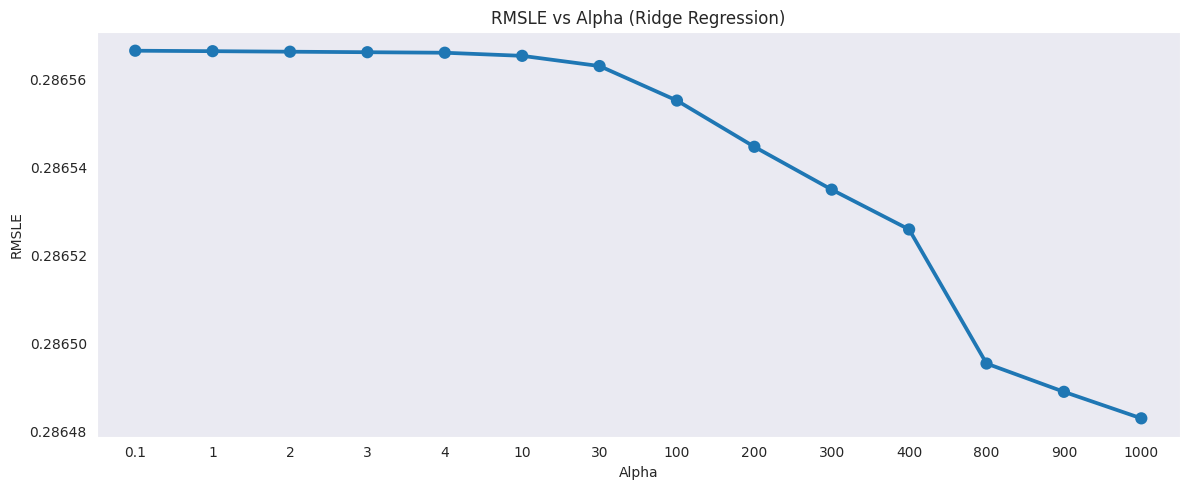

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings

warnings.filterwarnings("ignore")

# Define RMSLE function
def rmsle(y_true, y_pred, print_result=True):
    y_pred = np.maximum(0, y_pred)
    log_true = np.log1p(y_true)
    log_pred = np.log1p(y_pred)
    score = np.sqrt(np.mean((log_true - log_pred) ** 2))
    if print_result:
        print(f"RMSLE: {score}")
    return score

# Ridge regression setup
ridge_m_ = Ridge()
ridge_params_ = {
    'max_iter': [3000],
    'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]
}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

# Transform target variable
yLabelsLog = np.log1p(yLabels)

# Fit GridSearchCV
grid_ridge_m = GridSearchCV(ridge_m_, ridge_params_, scoring=rmsle_scorer, cv=5)
grid_ridge_m.fit(dataTrain, yLabelsLog)

# Predict
preds = grid_ridge_m.predict(dataTrain)
print(grid_ridge_m.best_params_)
print("RMSLE Value For Ridge Regression:", rmsle(np.expm1(yLabelsLog), np.expm1(preds), False))

# Plotting
results = grid_ridge_m.cv_results_
df = pd.DataFrame({
    'alpha': results['param_alpha'].data,
    'rmsle': -results['mean_test_score']
})

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
sn.pointplot(data=df, x='alpha', y='rmsle', ax=ax)
ax.set_title('RMSLE vs Alpha (Ridge Regression)')
ax.set_ylabel('RMSLE')
ax.set_xlabel('Alpha')
plt.tight_layout()
plt.show()


RMSLE: 0.3962531940273644
RMSLE: 0.28113641816408264
RMSLE: 0.33653904068863816
RMSLE: 0.2934023135044305
RMSLE: 0.2794046714704933
RMSLE: 0.3592869437310503
RMSLE: 0.2650257457660945
RMSLE: 0.2998321798571798
RMSLE: 0.2604911191176234
RMSLE: 0.25815447938771496
RMSLE: 0.3524254451344682
RMSLE: 0.2676590813403707
RMSLE: 0.29796354451509305
RMSLE: 0.25978408476574727
RMSLE: 0.25819269063154554
RMSLE: 0.3502722914244775
RMSLE: 0.2687646453929687
RMSLE: 0.2974119353321646
RMSLE: 0.2596714318845601
RMSLE: 0.25831048923705746
RMSLE: 0.349258761506021
RMSLE: 0.2693440410085486
RMSLE: 0.2971729013812871
RMSLE: 0.25963984052391287
RMSLE: 0.2584104927771059
RMSLE: 0.34750369384276614
RMSLE: 0.27022695949045783
RMSLE: 0.29688374852777333
RMSLE: 0.2593918896413212
RMSLE: 0.25866034311646285
RMSLE: 0.3467527736946802
RMSLE: 0.2706034431809724
RMSLE: 0.2968145324140883
RMSLE: 0.2593028535845227
RMSLE: 0.25880019850807473
RMSLE: 0.3464942384547373
RMSLE: 0.27073843583809565
RMSLE: 0.2967990498880716

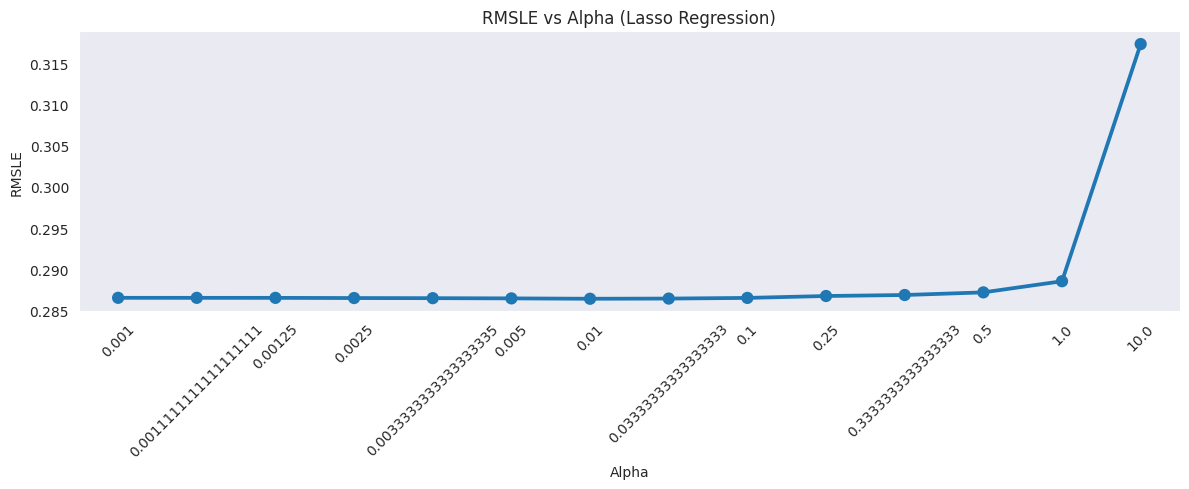

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings

warnings.filterwarnings("ignore")

# Define RMSLE function
def rmsle(y_true, y_pred, print_result=True):
    y_pred = np.maximum(0, y_pred)
    log_true = np.log1p(y_true)
    log_pred = np.log1p(y_pred)
    score = np.sqrt(np.mean((log_true - log_pred) ** 2))
    if print_result:
        print(f"RMSLE: {score}")
    return score

# Create scorer
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

# Define Lasso model and parameters
lasso_m_ = Lasso()
alpha = 1 / np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params_ = { 'max_iter': [3000], 'alpha': alpha }

# Log-transform target
yLabelsLog = np.log1p(yLabels)

# Fit Lasso model with GridSearchCV
grid_lasso_m = GridSearchCV(lasso_m_, lasso_params_, scoring=rmsle_scorer, cv=5)
grid_lasso_m.fit(dataTrain, yLabelsLog)

# Predict and evaluate
preds = grid_lasso_m.predict(dataTrain)
print("Best Params:", grid_lasso_m.best_params_)
print("RMSLE Value For Lasso Regression:", rmsle(np.expm1(yLabelsLog), np.expm1(preds), False))

# Plot results
results = grid_lasso_m.cv_results_
df = pd.DataFrame({
    'alpha': results['param_alpha'].data,
    'rmsle': -results['mean_test_score']
})

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
sn.pointplot(data=df, x='alpha', y='rmsle', ax=ax)
ax.set_title('RMSLE vs Alpha (Lasso Regression)')
ax.set_ylabel('RMSLE')
ax.set_xlabel('Alpha')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [37]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)
yLabelsLog = np.log1p(yLabels)
rfModel.fit(dataTrain,yLabelsLog)
preds = rfModel.predict(X= dataTrain)
print ("RMSLE Value For Random Forest: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Random Forest:  0.8253242544355106


In [38]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01); ### Test 0.41
yLabelsLog = np.log1p(yLabels)
gbm.fit(dataTrain,yLabelsLog)
preds = gbm.predict(X= dataTrain)
print ("RMSLE Value For Gradient Boost: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))


RMSLE Value For Gradient Boost:  1.0001078513949595


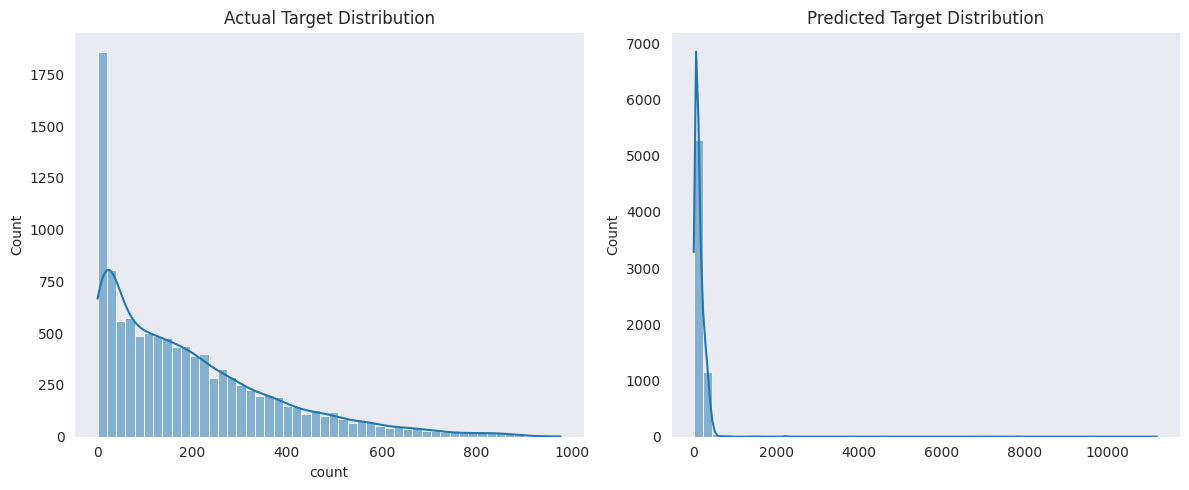

In [41]:
# Ensure test data has same columns as training data
dataTest = dataTest[dataTrain.columns]

# Predict using the trained GBM model
predsTest = gbm.predict(dataTest)

# Plot distributions
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
sn.histplot(yLabels, ax=ax1, bins=50, kde=True)
sn.histplot(np.expm1(predsTest), ax=ax2, bins=50, kde=True)
ax1.set_title("Actual Target Distribution")
ax2.set_title("Predicted Target Distribution")
plt.tight_layout()
plt.show()


In [42]:
submission = pd.DataFrame({
        "datetime": datetimecol,
        "count": [max(0, x) for x in np.exp(predsTest)]
    })
submission.to_csv('bike_predictions_gbm_separate_without_fe.csv', index=False)